Learn iterator for multiphase elastic problems using PAC-FEANet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
from functools import reduce

from utils import plot
import feanet.pac as pac
from feanet.model import PACFEANet
from feanet.jacobi import JacobiBlock
from data.dataset import ThermalDataSet

Test PAC-FEANet for thermal problems 

In [2]:
device_predict = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #torch.device('cpu') #
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
train = True # True or False
smoother_model = 'thermal_type2_1phase_33x33_smoother'
model_name = 'thermal_type2_nphase_33x33_attention'
training_set = ThermalDataSet('data/thermal/thermal_type2_nphase_33x33.h5', device)
model_dir = 'model/learn_iterator/thermal_type2'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

nb_layers = 3
bs = 20
train_dataloader = DataLoader(training_set, batch_size=bs, shuffle=True)
dirich_idx_train, dirich_value_train, neumann_idx_train, neumann_value_train, material_train, f_train, u_train = next(iter(train_dataloader))
k = 0 # the index of training data to be shown

In [4]:
n_test = 2**5
test_set = ThermalDataSet('data/thermal/thermal_type2_nphase_33x33.h5', device)

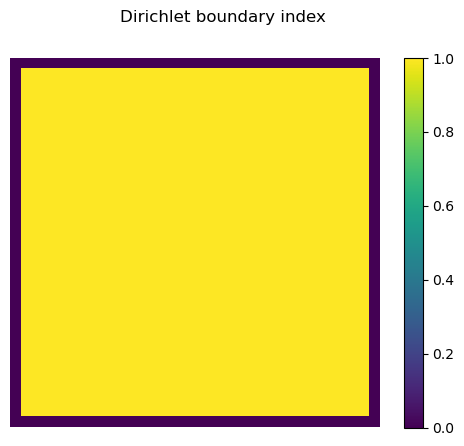

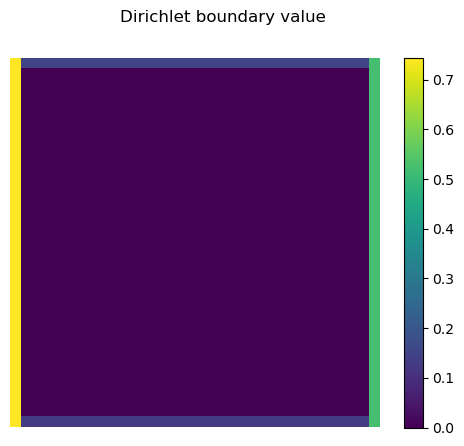

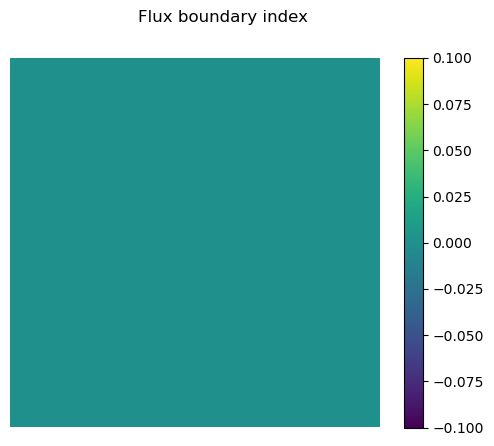

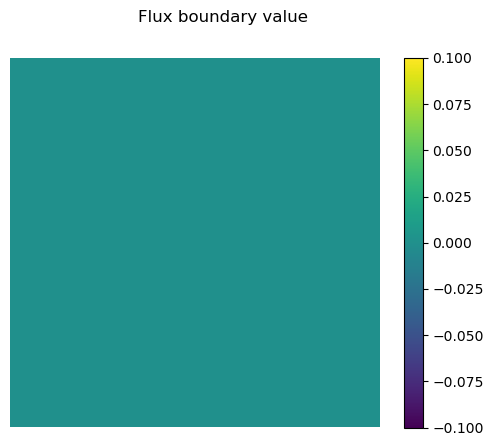

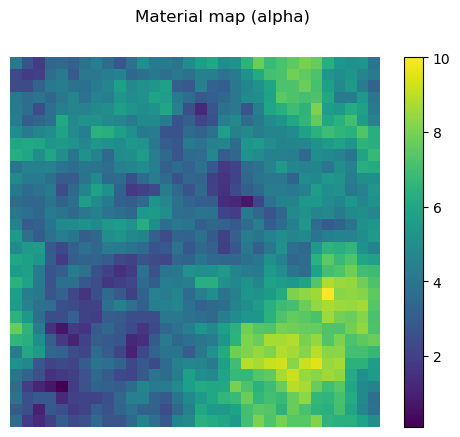

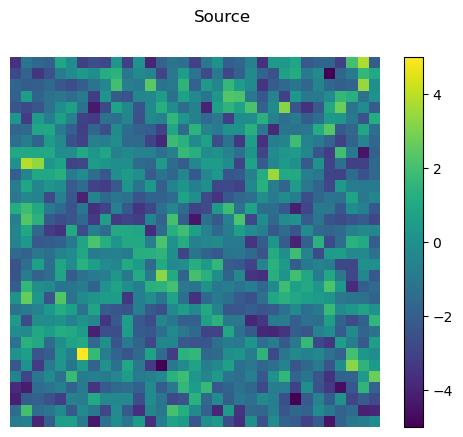

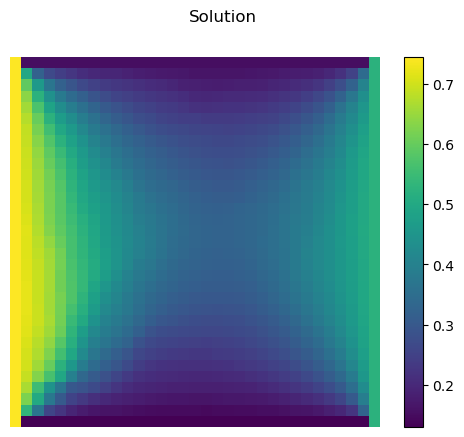

''

In [5]:
plot.plot_thermalfield(dirich_idx_train[k], ftitle='Dirichlet boundary index')

plot.plot_thermalfield(dirich_value_train[k], ftitle='Dirichlet boundary value')
plot.plot_thermalfield(neumann_idx_train[k], ftitle='Flux boundary index')
plot.plot_thermalfield(neumann_value_train[k], ftitle='Flux boundary value')
plot.plot_thermalfield(material_train[k], ftitle='Material map (alpha)')
plot.plot_thermalfield(f_train[k], ftitle='Source')
plot.plot_thermalfield(u_train[k], ftitle='Solution')
''''''

In [6]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    '''
    def __init__(self, size, n_elem, mode, dev):
        self.size = size # actual size of the plate
        self.mode = mode
        self.device = dev
        self.n_elem = n_elem
        self.h = size/n_elem
        self.v = torch.zeros((1, 1, n_elem+1, n_elem+1), requires_grad=False).double()
        self.f = torch.zeros((1, 1, n_elem+1, n_elem+1), requires_grad=False).double()
        self.net = self.InstantiateNetwork()
        self.jac = JacobiBlock(self.net, self.h, self.device, self.mode)

    def IsCoarsest(self):
        return self.n_elem == 2
        
    def InstantiateNetwork(self):
        model = PACFEANet(self.device, self.mode).double()
        model.requires_grad_(False)
        return model.to(self.device)

In [7]:
domain_size = 2
n_elem = 2**5
ku, kf = 1, 1
h = domain_size/n_elem
grid = SingleGrid(domain_size, n_elem=n_elem, mode='thermal', dev=device_predict)

In [8]:
solution_test, f_test, d_test, d_idx_test, t_test, t_idx_test, m_test = (torch.unsqueeze(u_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_train[k], 0).to(device_predict))


0 39.33836406127405
1 21.897062902012035
2 15.73358725430511
3 12.508431479291406
4 10.50086763781001
5 9.120254966217392
6 8.107430686359844
7 7.329962575059334
8 6.7127307731320744
9 6.209755273445643
10 5.79121517651611
11 5.4368735967615685
12 5.132491606584008
13 4.8677517786068725
14 4.634994611035234
15 4.428416761529883
16 4.2435439412851546
17 4.076873781247935
18 3.9256275857523923
19 3.7875739706724905
20 3.6609012097601337
21 3.5441233352954375
22 3.4360100879441458
23 3.335534002173898
24 3.241829984500862
25 3.154164117405509
26 3.071909354507487
27 2.994526416641059
28 2.9215486502936905
29 2.85256993127785
30 2.7872349279671678
31 2.725231206947551
32 2.6662827878427087
33 2.610144846003975
34 2.556599330527299
35 2.5054513169085366
36 2.4565259530212447
37 2.4096658872061756
38 2.364729090429796
39 2.321587002409056
40 2.2801229455725975
41 2.2402307616724078
42 2.201813634477618
43 2.1647830688021097
44 2.1290580015420595
45 2.0945640247342037
46 2.061232704125619
47 

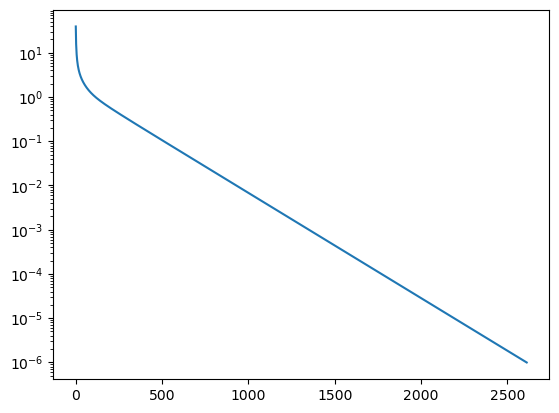

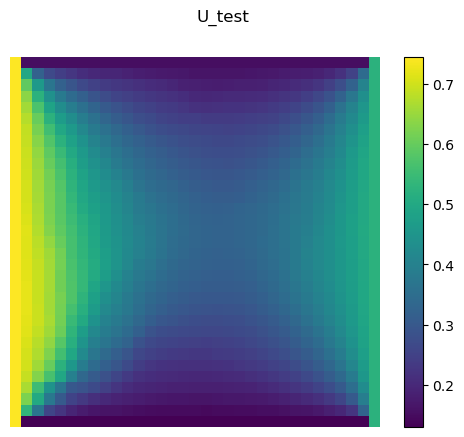

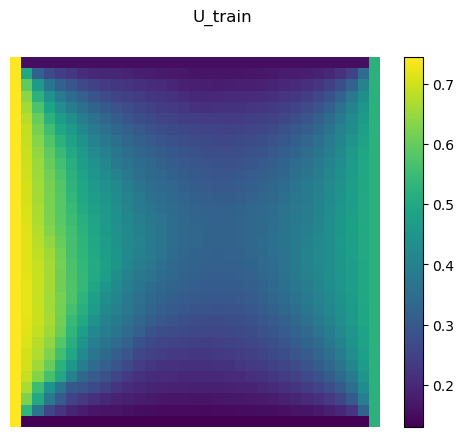

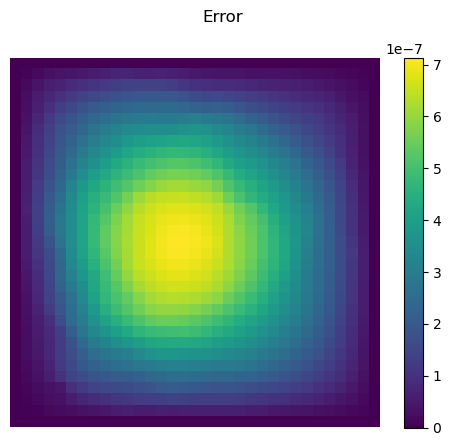

In [9]:
EPS = 1e-6
n_jac = 0
u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
u_test = grid.jac.reset_boundary(u_test, d_test, d_idx_test)
residual = d_idx_test*grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
res = torch.norm(residual).item() 
res_arr = [res]

print(n_jac, res)
while (abs(res) > EPS):
    u_test = grid.jac.jacobi_convolution(u_test, m_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_idx_test)
    residual = d_idx_test*grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item() 
    res_arr.append(res)
    n_jac += 1
    print(n_jac, res)

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

plot.plot_thermalfield(u_test[0], "U_test")
plot.plot_thermalfield(solution_test[0], "U_train")
plot.plot_thermalfield(u_test[0]-solution_test[0], 'Error')

In [10]:
class PsiNet(nn.Module):
    def __init__(self, nb_layers=3, mode='thermal'):
        super(PsiNet, self).__init__()

        self.mode = mode
        self.kernel = 3
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2
            
        self.smoother = nn.ModuleList([nn.Conv2d(self.ku, self.ku, 3, padding=1, bias=False)
                                         for _ in range(nb_layers)])

    def forward(self, m, x, dirich_idx):
        '''
        m: material field
        x: error between Jacobi solution and initial guess '''
        
        return reduce(lambda acc, el: el(acc) * dirich_idx, self.smoother, x) # shape (bs, ku, h, w)

In [11]:
class AttentionNet(nn.Module):
    def __init__(self, nb_layers=3, mode='thermal'):
        super(AttentionNet, self).__init__()

        self.mode = mode
        self.k_size = 3
        self.nb_layers = nb_layers
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2
            
        self.attention_map = nn.Sequential(
            nn.Conv2d(self.km, 1, kernel_size=2, padding=1),
            nn.Conv2d(1, 1, kernel_size=5, padding=2),
            nn.Conv2d(1, 1, kernel_size=5, padding=2),
            nn.Conv2d(1, 1, kernel_size=5, padding=2),
            nn.Conv2d(1, self.k_size*self.k_size, kernel_size=self.k_size//2),
            #nn.BatchNorm2d(self.kernel*self.kernel)
            )
        
        self.pac_conv = nn.ModuleList([pac.PacConv2d(self.ku, self.ku, 3, padding=1, bias=False)
                                         for _ in range(nb_layers)])

    def forward(self, x, m, smoother, dirich_idx):
        '''
        x: error between Jacobi solution and initial guess 
        smoother: learned smoother (Psi) network '''

        bs0, ku0, h0, w0 = x.size()
        
        # get the material kernels
        attention_kernels = self.attention_map(m).view(bs0, 1, self.k_size, self.k_size, h0, w0) # shape (bs, 1, 3, 3, h, w)
        smoother_list = list(smoother.parameters())

        new_x = x.clone()
        for i in range(self.nb_layers):
            self.pac_conv[i].state_dict()['weight'].copy_(smoother_list[i]) # copy the smoother to PAC
            new_x = self.pac_conv[i](new_x, None, attention_kernels)
            new_x = new_x*dirich_idx # error at dirichlet boundary is zero

        return new_x

In [12]:
class PsiIterator(nn.Module):
    def __init__(self, 
                 dev,
                 size=2, 
                 psi_net=None,
                 att_net=None,
                 grid=None,
                 n=2**5,
                 nb_layers=3,
                 batch_size=1,
                 max_epochs=1000,
                 mode='thermal',
                 model_dir=model_dir):
        super(PsiIterator, self).__init__()
        self.size = size
        self.device = dev
        self.n = n
        self.h = size/n
        self.mode = mode
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.loss = nn.MSELoss()
        
        if(grid is None):
            self.grid = SingleGrid(size, n, mode=mode, dev=self.device)
        else:
            self.grid = grid

        if(psi_net is None):
            self.psi_net = PsiNet(nb_layers=nb_layers, mode=self.mode).to(self.device).double()
        else:
            self.psi_net = psi_net.to(self.device).double()
        self.psi_net.requires_grad_(False)

        if(att_net is None):
            self.att_net = AttentionNet(nb_layers=nb_layers, mode=self.mode).to(self.device).double()
        else:
            self.att_net = att_net.to(self.device).double()

        self.optimizer = torch.optim.Adadelta(self.att_net.parameters())
        self.model_dir=model_dir

    def PsiRelax(self, v, m, d, d_idx, term_KU=None, term_F=None, h=None, f=None, t=None, t_idx=None, num_sweeps_down=1):
        '''
        Perform a fixed number of Psi iteration
        '''
        u = v.clone()
        for _ in range(num_sweeps_down):
            jac_it = self.grid.jac.jacobi_convolution(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx)
            u = jac_it + self.att_net(jac_it-u, m, self.psi_net, d_idx) 
        return u

    def RandomSampling(self, x):
        u = torch.randn_like(x).double().to(self.device)
        return u

    def TrainSingleEpoch(self, train_dataloader):
        running_loss = 0.
        for i, data in enumerate(train_dataloader):
            self.psi_net.train()
            dirich_idx_train, dirich_value_train, traction_idx_train, traction_value_train, material_train, f_train, u_train = data
        
            #print(u_train.shape)
            self.optimizer.zero_grad() # zero the gradients for every batch
            k = 1 #random.randint(1,20)

            uu = self.RandomSampling(f_train)
            u_out = self.PsiRelax(uu, material_train, dirich_value_train, dirich_idx_train, None, None, self.h, f_train, traction_value_train, traction_idx_train, k)
            loss_i = self.loss(u_out, u_train)
            loss_i.backward()
            self.optimizer.step()
        
            running_loss += loss_i.item()
    
        last_loss = running_loss/(i+1)
        return last_loss
    
    def Train(self, training_set):
        train_dataloader = DataLoader(training_set, batch_size=self.batch_size, shuffle=True)
        loss_train = torch.zeros((self.max_epochs, 1))
        avg_loss = self.TrainSingleEpoch(train_dataloader)
        loss_train[0] = avg_loss
        print('Step-0 loss:', avg_loss)

        for epoch in range(1, self.max_epochs):
            avg_loss = self.TrainSingleEpoch(train_dataloader)
            if(epoch % 50 == 0):
                print('Step-'+str(epoch)+' loss:', avg_loss)

            # save the model's state
            mpath = os.path.join(self.model_dir,model_name+'.pth')
            torch.save(self.att_net.state_dict(), mpath)
            loss_train[epoch] = avg_loss
        return loss_train

Step-0 loss: 0.8965224186625061
Step-50 loss: 0.716820813707901
Step-100 loss: 0.7212426009181537
Step-150 loss: 0.7111347078916768
Step-200 loss: 0.703567208377444
Step-250 loss: 0.7087429747274533
Step-300 loss: 0.7037804380702559
Step-350 loss: 0.7033181047464545
Step-400 loss: 0.7048076456976574
Step-450 loss: 0.7067053915050252
Step-500 loss: 0.7136593886347399
Step-550 loss: 0.7144105644380043
Step-600 loss: 0.7076311701302308
Step-650 loss: 0.7112203751148859
Step-700 loss: 0.7058612045576802
Step-750 loss: 0.7035017099482672
Step-800 loss: 0.704546029097704
Step-850 loss: 0.7043749838846075
Step-900 loss: 0.7052755291300198
Step-950 loss: 0.7021060304631364
Step-1000 loss: 0.7108052985877393
Step-1050 loss: 0.7181963568767898
Step-1100 loss: 0.7066972392286415
Step-1150 loss: 0.7064754003676105
Step-1200 loss: 0.6940438063250924
Step-1250 loss: 0.7118808408915802
Step-1300 loss: 0.7112806173512553
Step-1350 loss: 0.7083197880108737
Step-1400 loss: 0.7067155033713565
Step-1450 l

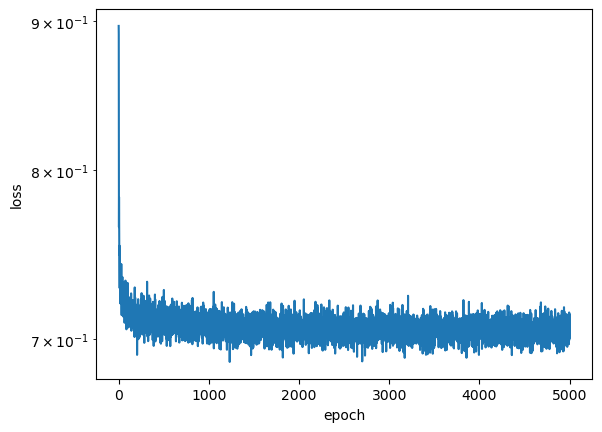

In [13]:
max_epochs = 5000
psi_net = PsiNet(nb_layers=nb_layers, mode='thermal').to(device_predict)
psi_net.load_state_dict(torch.load(os.path.join(model_dir,smoother_model+'.pth')))

my_iterator = PsiIterator(device, batch_size=bs, mode='thermal', psi_net=psi_net, nb_layers=nb_layers, max_epochs=max_epochs)

loss_train = torch.zeros((max_epochs, 1))
if(train):
    loss_train = my_iterator.Train(training_set)

    plt.plot(loss_train)
    plt.ylabel('loss')
    plt.yscale('log')
    plt.xlabel('epoch')
    print("Average loss: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

    # save the list
    torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))


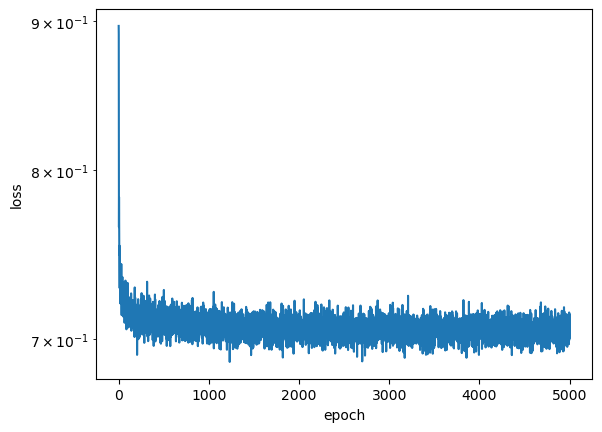

In [14]:
# import the learned model and loss train
new_iterator = PsiIterator(device_predict, psi_net=psi_net, nb_layers=nb_layers, grid=grid, batch_size=1)
new_iterator.att_net.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))

my_loss = torch.load(os.path.join(model_dir,model_name+'.pt'))
plt.plot(my_loss)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.savefig('results/smoother_loss.jpg', dpi=500, bbox_inches='tight')

0 39.33836406127405
1 25.41980743693976
2 19.240795450180183
3 16.726704561816387
4 16.05378704993439
5 16.198546326229298
6 16.64757310658478
7 17.17633039624873
8 17.69809703798483
9 18.185841431729205
10 18.636863434248312
11 19.057538205693362
12 19.456936294053104
13 19.844322434461453
14 20.228346626620255
15 20.61697003499496
16 21.017704508341385
17 21.437983999698798
18 21.885595376021016
19 22.36914640302674
20 22.898571500355537
21 23.485685131070195
22 24.144794534856366
23 24.893380453617816
24 25.75284750833705
25 26.74933564173442
26 27.914571879161496
27 29.286730360650687
28 30.911262693744128
29 32.84166573547189
30 35.140174340920254
31 37.87840240965943
32 41.13799977058339
33 45.01143194992377
34 49.603010643230526
35 55.03029729077706
36 61.42597422878395
37 68.94024041402952
38 77.74375682261402
39 88.03115043286459
40 100.02508745252676
41 113.98094225867503
42 130.19211222105127
43 148.99605489047278
44 170.78114990892107
45 195.9945125294335
46 225.15090930919

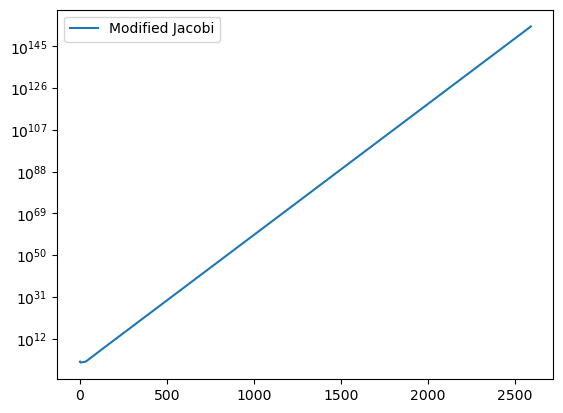

In [15]:
EPS = 1e-6
with torch.no_grad():
    n_new = 0
    u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
    u_test = new_iterator.grid.jac.reset_boundary(u_test, d_test, d_idx_test)
    residual = d_idx_test*new_iterator.grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item() # fix top, apply traction force at bottom boundary
    res_arr_new = [res]
    print(n_new, res)
    while (abs(res) > EPS and n_new < 5000):
        u_test = new_iterator.PsiRelax(u_test, m_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*new_iterator.grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_new.append(res)
        n_new += 1
        print(n_new, res)

print("Solution converges after", n_new, "iterations ")
plt.plot(res_arr_new, label='Modified Jacobi')
#plt.plot(res_arr, label='Jacobi')
plt.yscale('log')
plt.legend()
plt.show()

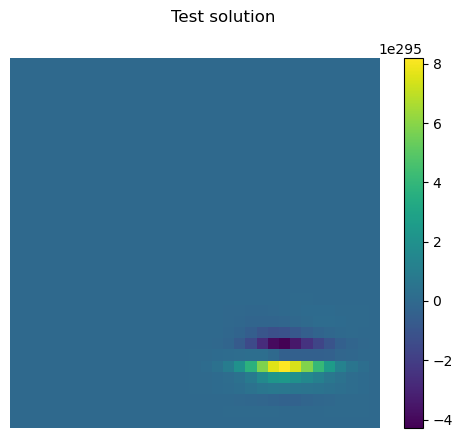

In [16]:
plot.plot_thermalfield(u_test[0], 'Test solution')

In [17]:
# test multigrid performance

class RestrictionNet(nn.Module):
    '''Given an initial kernel, inter-grid communication'''
    def __init__(self, chs):
        super(RestrictionNet, self).__init__()
        self.chs = chs
        self.net = nn.Conv2d(in_channels=chs, out_channels=chs, kernel_size=3, stride=2, bias=False, groups=chs) # restriction
        self.edge_net = nn.Conv1d(in_channels=chs, out_channels=chs, kernel_size=3, stride=2, bias=False, groups=chs) # restrict the edge boundaries
        for i in range(self.chs):
            self.net.state_dict()['weight'][i][0] = torch.asarray([[1., 2., 1.],
                                                                   [2., 4., 2.],
                                                                   [1., 2., 1.]]) / 4.0
            self.edge_net.state_dict()['weight'][i][0] = torch.asarray([1., 2., 1.]) / 2.0
    
    def forward(self, x):
        internal = self.net(x[:, :, 1:-1, 1:-1].clone())
        x_C = F.pad(internal,(1,1,1,1),"constant",0) # coarse grid field
        x_C[:, :,  0, 1:-1] = self.edge_net(x[:, :, 0, 1:-1].clone())
        x_C[:, :, -1, 1:-1] = self.edge_net(x[:, :, -1, 1:-1].clone())
        x_C[:, :, 1:-1,  0] = self.edge_net(x[:, :, 1:-1, 0].clone())
        x_C[:, :, 1:-1, -1] = self.edge_net(x[:, :, 1:-1, -1].clone())
        x_C[:,:,0,0] = x[:,:,0,0]
        x_C[:,:,0,-1] = x[:,:,0,-1]
        x_C[:,:,-1,0] = x[:,:,-1,0]
        x_C[:,:,-1,-1] = x[:,:,-1,-1]
        return x_C


class ProlongationNet(nn.Module):
    '''Given an initial P kernel'''
    def __init__(self, chs):
        super(ProlongationNet, self).__init__()
        self.chs = chs
        self.net = nn.ConvTranspose2d(in_channels=chs,out_channels=chs, kernel_size=3, stride=2, padding=1, bias=False, groups=chs) # interpolation
        for i in range(self.chs):
            self.net.state_dict()['weight'][i][0] = torch.asarray([[1., 2., 1.],
                                                                   [2., 4., 2.],
                                                                   [1., 2., 1.]]) / 4.0
            
    def forward(self, x): 
        return self.net(x)

In [18]:
class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n, pacnet, attnet, device, nb_layers, mode='thermal', iterator = 'jac'):
        super(MultiGrid, self).__init__()

        # Problem parameters
        self.device = device
        self.size = 2.
        self.nb_layers = nb_layers
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.pacnet = pacnet
        self.attnet = attnet
        self.iterator = iterator
        
        self.mode = mode
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2

        self.iterators = self.IteratorDict() # dictionary of iterators

        # Inter-grid communication network models
        self.conv = RestrictionNet(self.kf).double().to(device)
        self.deconv = ProlongationNet(self.ku).double().to(device)
        
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)

        self.mse_loss = nn.MSELoss()
    
    def IteratorDict(self):
        iterators = {}
        for i in range(self.L):
            prob_size = int(self.n/(2.**i))
            iterators[i] = PsiIterator(self.device, size=self.size, psi_net=self.pacnet, att_net=self.attnet, n=prob_size, nb_layers=self.nb_layers, mode=self.mode)
        return iterators
            
    def ProblemDictArray(self, u0, f, t, t_idx, d, d_idx, m):
        '''
        Array of dictionary that stores the problem hierarchy
        There are two approaches that can be used to create grid hierarchy:
        1) mat = F.conv2d(mat.reshape((1,1,n,n)), torch.ones((1,1,1,1)), stride=2)
        2) mat = F.max_pool2d(mat.reshape((1,1,n,n)), kernel_size=2, stride=2)
        '''
        kernel_u = torch.ones((self.ku,1,1,1)).double().to(self.device)
        kernel_f = torch.ones((self.kf,1,1,1)).double().to(self.device)
        prob = {}
        prob['h'] = self.size/self.n
        prob['u0'] = self.iterators[0].grid.jac.reset_boundary(u0, d, d_idx)
        prob['f'], prob['t'], prob['t_idx'] = f.clone(), t.clone(), t_idx.clone()
        prob['d'], prob['d_idx'], prob['m'] = d.clone(), d_idx.clone(), m.clone()
        self.p_arr = [prob]
        for i in range(self.L-1):
            prob = {}
            prob['h'] = self.size/self.n*(2.**(i+1))
            prob['u0'] = F.conv2d(self.p_arr[i]['u0'], kernel_u, stride=2, groups=self.ku)
            prob['f'] = F.conv2d(self.p_arr[i]['f'], kernel_f, stride=2, groups=self.kf)
            prob['t'] = F.conv2d(self.p_arr[i]['t'], kernel_f, stride=2, groups=self.kf)
            prob['t_idx'] = F.conv2d(self.p_arr[i]['t_idx'], kernel_f, stride=2, groups=self.kf)
            prob['d'] = 0.*F.conv2d(self.p_arr[i]['d'], kernel_u, stride=2, groups=self.ku) # Dirichlet boundary is homogeneous at coarse grids
            prob['d_idx'] = F.conv2d(self.p_arr[i]['d_idx'], kernel_u, stride=2, groups=self.ku)
            prob['m'] = F.max_pool2d(self.p_arr[i]['m'], kernel_size=2, stride=2)
            self.p_arr.append(prob)

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        '''
        rFC = self.conv(rF.clone())
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def forward(self, k):
        U = self.p_arr[0]['u0'].clone()
        for i in range(k-1):
            U = self.Step(U).detach()
        self.last_v = U.clone()
        return self.Step(U)

    def Relax(self, iter, u, m, d, d_idx, term_KU=None, term_F=None, h=None, f=None, t=None, t_idx=None, n_iter=1):
        if(self.iterator == 'jac'):
            return iter.grid.jac.jacobi_convolution(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx)
        else:
            return iter.PsiRelax(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx, n_iter)

    def Step(self, v):
        '''Input v is the initial solution on the finest grid'''
        n_relax = 1 # number of relaxations        
        self.iterators[0].grid.v = self.Relax(self.iterators[0], v, self.p_arr[0]['m'], 
                                              self.p_arr[0]['d'], self.p_arr[0]['d_idx'],
                                              None, None,
                                              self.p_arr[0]['h'], self.p_arr[0]['f'], 
                                              self.p_arr[0]['t'], self.p_arr[0]['t_idx'], 
                                              n_relax)
        self.iterators[0].grid.f = self.iterators[0].grid.net.term_F

        for j in range(0, self.L-1):
            # calculate fine grid residual
            rF = self.iterators[j].grid.net(u=self.iterators[j].grid.v, material_input=self.p_arr[j]['m'],
                                            term_F=self.iterators[j].grid.f)
            self.iterators[j+1].grid.f = self.Restrict(rF)
            self.iterators[j+1].grid.v = torch.zeros_like(self.iterators[j+1].grid.f) 
            self.iterators[j+1].grid.v = self.Relax(self.iterators[j+1], self.iterators[j+1].grid.v, 
                                              self.p_arr[j+1]['m'], 
                                              self.p_arr[j+1]['d'], self.p_arr[j+1]['d_idx'],
                                              term_F=self.iterators[j+1].grid.f, 
                                              n_iter=n_relax)

        self.iterators[self.L-1].grid.v = self.Relax(self.iterators[self.L-1], self.iterators[self.L-1].grid.v, 
                                              self.p_arr[self.L-1]['m'], 
                                              self.p_arr[self.L-1]['d'], self.p_arr[self.L-1]['d_idx'],
                                              term_F=self.iterators[self.L-1].grid.f, 
                                              n_iter=n_relax)

        for j in range(self.L-2,-1,-1):
            eF_delta = self.Interpolate(self.iterators[j+1].grid.v)
            self.iterators[j].grid.v = self.iterators[j].grid.v + eF_delta
            self.iterators[j].grid.v = self.Relax(self.iterators[j], self.iterators[j].grid.v, 
                                              self.p_arr[j]['m'], 
                                              self.p_arr[j]['d'], self.p_arr[j]['d_idx'],
                                              term_F=self.iterators[j].grid.f, 
                                              n_iter=n_relax)

            # zero out the previous level solution
            self.iterators[j+1].grid.v *= 0. 

        return self.iterators[0].grid.v 

In [19]:
bs = 5
train_dataloader = DataLoader(test_set, batch_size=bs, shuffle=True)
dirich_idx_train, dirich_value_train, neumann_idx_train, neumann_value_train, material_train, f_train, u_train = next(iter(train_dataloader))
k=2
solution_test, f_test, d_test, d_idx_test, t_test, t_idx_test, m_test = (torch.unsqueeze(u_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_train[k], 0).to(device_predict))


In [20]:
with torch.no_grad():
    n = n_test
    h = 2./n
    n_mg_jac = 0
    mg_jac = MultiGrid(n=n, pacnet=psi_net, attnet=new_iterator.att_net, nb_layers=nb_layers, device=device, iterator='jac') # create a multigrid model
    u_mg_jac = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    mg_jac.ProblemDictArray(u_mg_jac,f_test,t_test,t_idx_test,d_test,d_idx_test,m_test)
    u_mg_jac = mg_jac.p_arr[0]['u0']
    residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgjac = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        #u_mg = mg_jac.Relax(mg_jac.iterators[0], u_mg, m_test, d_test,d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_mgjac.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')


0 32.95424914984076
1 7.235987671645343
2 1.7960451481394677
3 0.4642088375215963
4 0.1260014032714615
5 0.036639591721068204
6 0.011757694528059285
7 0.004280207261431283
8 0.0017667846269859005
9 0.0007999583345685964
10 0.0003820093534870439
11 0.00018731304596459274
12 9.296574621530167e-05
13 4.637852229671729e-05
14 2.3181116339476868e-05
15 1.1591174067260956e-05
16 5.79446279843386e-06
17 2.8952261924839976e-06
18 1.4458006923213249e-06
19 7.216080262965803e-07
Solution converges after 19 Jacobi multigrid iterations in 0.16372394561767578 seconds.


In [21]:
with torch.no_grad():
    h = 2./n
    n_mg_psi = 0
    mg_jac = MultiGrid(n=n, pacnet=psi_net, attnet=new_iterator.att_net, nb_layers=nb_layers, device=device, iterator='psi') # create a multigrid model
    u_mg_psi = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    mg_jac.ProblemDictArray(u_mg_psi,f_test,t_test,t_idx_test,d_test,d_idx_test,m_test)
    u_mg_psi = mg_jac.p_arr[0]['u0']
    residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_psi, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgpsi = [res]
    print(n_mg_psi, res)

    start = time.time()
    while (abs(res) > EPS and n_mg_psi < 1000):
        u_mg_psi = mg_jac.Step(u_mg_psi)
        #u_mg = mg_jac.Relax(mg_jac.iterators[0], u_mg, m_test, d_test,d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_psi, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_mgpsi.append(res)
        n_mg_psi += 1
        print(n_mg_psi, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_psi, "Psi-Jacobi multigrid iterations in", end-start, 'seconds.')


0 32.95424914984076
1 9.523996792997398
2 4.221880391893229
3 3.0799182057760595
4 2.8839739810035083
5 2.977433057587708
6 3.2277526450888265
7 3.6153609461805503
8 4.154366810757135
9 4.878949539204693
10 5.844422477958999
11 7.132422919399911
12 8.858425553880275
13 11.181884314204448
14 14.319990445784258
15 18.566483515172813
16 24.317407381214885
17 32.106251961988555
18 42.65167050165112
19 56.922025724388504
20 76.22250430676867
21 102.31256778368727
22 137.56424401722006
23 185.1754412863561
24 249.45741283374787
25 336.222156750129
26 453.3045024903815
27 611.2657162884349
28 824.3417373952249
29 1111.721095683123
30 1499.2671262154568
31 2021.8389390500015
32 2726.419295498219
33 3676.3298998367018
34 4956.912126193952
35 6683.182607508788
36 9010.150199932517
37 12146.719480563508
38 16374.427537359818
39 22072.69420423614
40 29752.84994250978
41 40103.99264131894
42 54054.78527793009
43 72856.73574976448
44 98196.42642925419
45 132346.75681804746
46 178370.76084522886
47 2

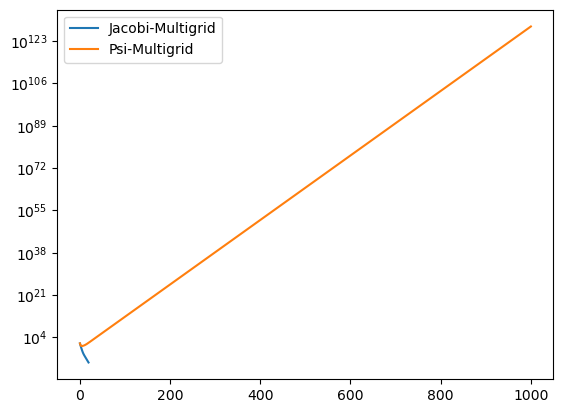

In [22]:
plt.plot(res_arr_mgjac, label='Jacobi-Multigrid')
plt.plot(res_arr_mgpsi, label='Psi-Multigrid')
plt.yscale('log')
plt.legend()
plt.show()

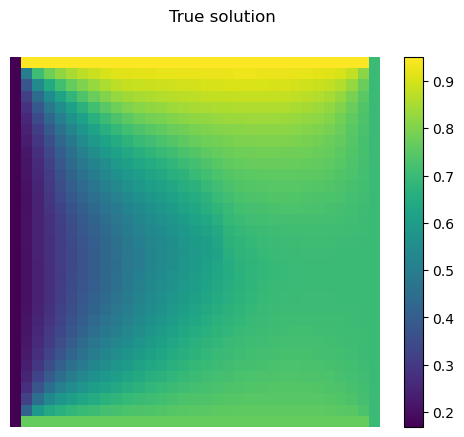

In [23]:
plot.plot_thermalfield((solution_test).reshape(n+1,n+1), 'True solution')

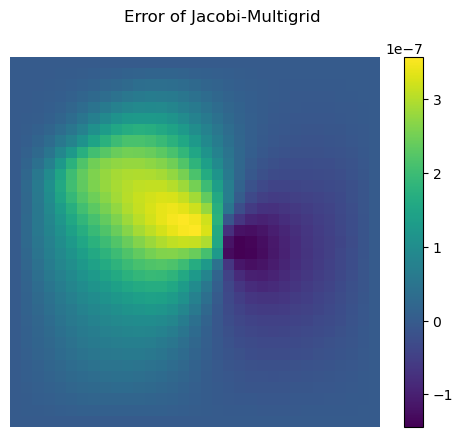

In [24]:
plot.plot_thermalfield((u_mg_jac-solution_test).reshape(n+1,n+1), 'Error of Jacobi-Multigrid')

In [25]:
u_mg_jac-solution_test

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, -5.6488e-11,  8.5953e-11,  ..., -6.1496e-10,
           -3.3774e-10,  0.0000e+00],
          [ 0.0000e+00, -4.1886e-11,  3.2062e-10,  ..., -1.3127e-09,
           -7.0316e-10,  0.0000e+00],
          ...,
          [ 0.0000e+00,  2.3057e-09,  4.8891e-09,  ..., -2.9730e-09,
           -1.5967e-09,  0.0000e+00],
          [ 0.0000e+00,  1.1359e-09,  2.4613e-09,  ..., -1.4108e-09,
           -7.6886e-10,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]]], device='cuda:0', dtype=torch.float64)

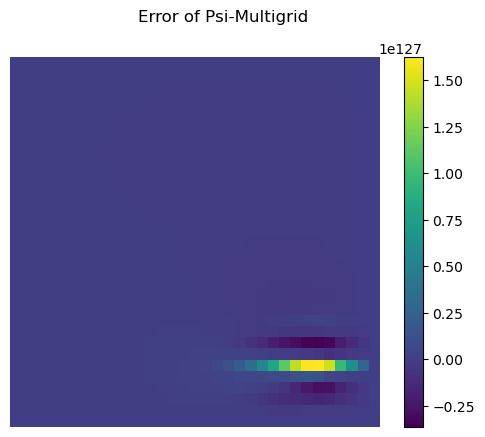

In [26]:
plot.plot_thermalfield((u_mg_psi.detach()-solution_test).reshape(n+1,n+1), 'Error of Psi-Multigrid')

In [27]:
u_mg_psi.detach()-solution_test

tensor([[[[  0.0000e+00,   0.0000e+00,   0.0000e+00,  ...,   0.0000e+00,
             0.0000e+00,   0.0000e+00],
          [  0.0000e+00, -5.3740e+121, -1.0803e+122,  ..., -5.4151e+122,
           -2.8305e+122,   0.0000e+00],
          [  0.0000e+00, -1.0263e+122, -2.0356e+122,  ..., -1.0919e+123,
           -5.6312e+122,   0.0000e+00],
          ...,
          [  0.0000e+00,  8.2107e+122,  1.7973e+123,  ..., -6.9551e+125,
           -2.9651e+125,   0.0000e+00],
          [  0.0000e+00,  4.1641e+122,  9.3288e+122,  ..., -2.0155e+125,
           -1.1115e+125,   0.0000e+00],
          [  0.0000e+00,   0.0000e+00,   0.0000e+00,  ...,   0.0000e+00,
             0.0000e+00,   0.0000e+00]]]], device='cuda:0',
       dtype=torch.float64)